## prompt

In [1]:
# import requests
# import json
# import re

# def preprocess_text(text):
#     # ตรวจสอบว่ามี IP address หรือคำว่า 'firewall' ในข้อความ
#     ip_pattern = re.compile(r'(\d{1,3}\.){3}\d{1,3}')
#     if ip_pattern.search(text) or 'firewall' in text.lower():
#         return 'close-open port'
#     else:
#         return 'request'

# text = ""

# category = preprocess_text(text)

# chat = f"""system
#     คุณเป็น AI ที่จะช่วยในการจัดประเภทอีเมล โปรดตอบว่าอีเมลนี้ควรอยู่ในประเภท "close-open port" หรือ "request" พร้อมกับเหตุผลสั้น ๆ ที่สมเหตุสมผลเป็นข้อ ๆ ดังนี้:
#     ข้อ 1: 
#     ข้อ 2: 
#     {{ end }}user
#     ข้อความอีเมล: {text}
#     assistant
#     """
# payload = { 
#     "inputs": chat, 
#     "parameters":{  
#         "best_of": 1,   
#         "decoder_input_details": False,
#         "details": False,   
#         "do_sample": False,   
#         "frequency_penalty": 1.5,    
#         "max_new_tokens": 200,
#         "repetition_penalty": 1.2,      
#         "return_full_text": False,         
#         "seed": 42,                          
#         "temperature": 0.01,             
#         "top_k": 5,                    
#         "top_p": 0.9,                                      
#         "watermark": False
#     }
# }

# url = 'https://ai-api.manageai.co.th/llm-model-02/generate'
# headers = {'Content-Type': 'application/json'}

# response = requests.post(url, headers=headers, data=json.dumps(payload))
# response = response.json()
# print(response)


**create function to get IP and can detect is it public or private ip**

In [2]:
# import re
# import ipaddress

# def extract_and_classify_ips(description):
#     ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
#     ips = re.findall(ip_pattern, description)
    
#     classified_ips = {'Public': [], 'Private': []}
#     for ip in ips:
#         try:
#             ip_obj = ipaddress.ip_address(ip)
#             if ip_obj.is_private:
#                 classified_ips['Private'].append(ip)
#             else:
#                 classified_ips['Public'].append(ip)
#         except ValueError:
#             # Skip the invalid IP address
#             continue
    
#     return classified_ips

In [3]:
# rm -rf /kaggle/working/*

# input

In [4]:
import pandas as pd
port = pd.read_csv('/kaggle/input/ticket/df_open_close_port.csv')
prob = pd.read_csv('/kaggle/input/ticket/df_problem_cloud.csv')
one = pd.read_csv('/kaggle/input/ticket/df_onemail.csv')
data = pd.read_csv('/kaggle/input/ticket/ticket.csv')
data = data.drop(columns=['category','sub_category', 'created_at'])

In [5]:
df = data.copy()

In [6]:
print(one['group'].unique())

['One-Email' 'One-Email [Exchange Mail]']


## label

In [7]:
import pandas as pd
import re

# Convert 'ticket_no' and 'subject' columns in prob and port to sets for fast lookups
prob_ticket_subject_set = set(zip(prob['ticket_no'].astype(str).values, prob['subject'].str.lower().values))
port_ticket_subject_set = set(zip(port['ticket_no'].astype(str).values, port['subject'].str.lower().values))
one_ticket_subject_set = set(zip(one['ticket_no'].astype(str).values, port['subject'].str.lower().values))

# Function to classify tickets
def classify_ticket(row):
    subject = str(row['subject']).lower() if pd.notnull(row['subject']) else ""
    description = str(row['description']).lower() if pd.notnull(row['description']) else ""
    group = str(row['group']).lower() if pd.notnull(row['group']) else ""
    service = str(row['service']).lower() if pd.notnull(row['service']) else ""
    ticket_no = str(row['ticket_no'])
    
    ticket_subject = (ticket_no, subject)

    # Check if the ticket is in the prob dataframe
    if ticket_subject in prob_ticket_subject_set:
        return 'problem'
    # Check if the ticket is in the port dataframe
    if ticket_subject in port_ticket_subject_set:
        return 'firewall'
    # Check if the ticket is in the one dataframe
    if ticket_subject in one_ticket_subject_set:
        return 'onemail'
    
    # Check for 'firewall' or IP address in subject or description
    if 'firewall' in subject or 'firewall' in description:
        return 'firewall'
    if re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', subject) or re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', description):
        return 'firewall'
    if 'network-security' in group or 'op-network-security' in service:
        return 'firewall'
    # Check for 'cloud' in any relevant column
    if 'cloud' in group or 'vmaas' in service or 'cloud' in service:
        return 'problem'
    # Check for 'one' in any relevant column
    if 'one-email' in group or 'one-email' in service:
        return 'onemail'
    # Default to 'other'
    return 'other'

# Apply the classification function
df['label'] = df.apply(classify_ticket, axis=1)

In [8]:
print(df['label'].value_counts())
print(df['label'].isnull().sum())

label
firewall    77098
other       66399
problem     65228
onemail     13764
Name: count, dtype: int64
0


In [9]:
sample_size = 13500

df_firewall = df[df['label'] == 'firewall'].sample(sample_size, random_state=42)
df_problem = df[df['label'] == 'problem'].sample(sample_size, random_state=42)
df_one = df[df['label'] == 'onemail'].sample(sample_size, random_state=42)
df_other = df[df['label'] == 'other'].sample(sample_size, random_state=42)

# Concatenate the samples into a new DataFrame
df_balanced = pd.concat([df_problem, df_firewall, df_other, df_one])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df = df_balanced.copy()

## clean

In [10]:
import re

def extract_email_subject(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return ""
    # Extract text after the last colon or bracket
    match = re.search(r"[:\]]\s*(.*)", text)
    return match.group(1).strip() if match else text

def extract_email_body(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return ""
    
    def extract_body(text):
        end_pos = re.search(r"(?i)(\b(best regards|thanks|sincerely|see you soon|regards|ขอบคุณครับ|ขอบคุณค่ะ)\b)", text)
        return text[:end_pos.start()].strip() if end_pos else text.strip()

    # Check if the email format has headers
    if re.search(r"^(From|To|Subject|Date|Message-ID):", text, re.MULTILINE):
        text = re.sub(r"Subject:.*\n", "", text, 1)  # Remove 'Subject:' line
        text = re.sub(r"-{50,}", "", text)  # Remove delimiters
    return extract_body(text)

df['clean_subject'] = df['subject'].apply(extract_email_subject)
df['clean_description'] = df['description'].apply(extract_email_body)

In [11]:
df['text'] = df['clean_subject'] + ' ' + df['clean_description']

In [12]:
import pandas as pd
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch

num_labels = 4
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=num_labels)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

2024-07-31 10:12:21.658830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 10:12:21.658931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 10:12:21.819055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [13]:
import numpy as np

label_mapping = {'firewall': 0, 'problem': 1, 'other': 2, 'onemail': 3}  # Adjust based on actual label set
df['label'] = df['label'].map(label_mapping)

# Split the data into training, validation, and test sets
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['label'])
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

# Apply tokenization
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [14]:
# Ensure labels are within range
num_labels = 4
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

assert all(0 <= label < num_labels for label in train_labels.numpy())
assert all(0 <= label < num_labels for label in val_labels.numpy())

# Check tensor shapes
print("Input IDs shape:", len(train_encodings['input_ids']))
print("Train labels shape:", train_labels.shape)

Input IDs shape: 37800
Train labels shape: torch.Size([37800])


In [15]:
# Create datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [16]:
!pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [17]:
import os
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import evaluate

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',           # Output directory
    num_train_epochs=3,               # Number of training epochs
    learning_rate=1e-5,
    per_device_train_batch_size=16,   # Batch size for training
    per_device_eval_batch_size=16,    # Batch size for evaluation
    weight_decay=0.01,                # Strength of weight decay
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=1000,
    eval_strategy="epoch",      # Evaluate every epoch
    save_strategy="epoch",            # Save checkpoint every epoch
    save_total_limit=1,               # Only save the most recent checkpoint
    report_to="none",                 # Disable reporting to wandb and other services
    load_best_model_at_end=True,      # Load the best model at the end of training
    metric_for_best_model="accuracy"
)

# Load the accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    report = classification_report(labels, predictions, output_dict=True)
    # Combine accuracy with the classification report
    return {**accuracy, **{key: value for key, value in report.items() if isinstance(value, (int, float))}}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


## train

In [18]:
# Train the model
trainer.train()

/tmp/ipykernel_24/581508825.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.461600,0.267096,0.898395
2,0.243200,0.233080,0.919012
3,0.203700,0.228808,0.920617


/tmp/ipykernel_24/581508825.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/tmp/ipykernel_24/581508825.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; wi

TrainOutput(global_step=3546, training_loss=0.28700368658540215, metrics={'train_runtime': 6485.8581, 'train_samples_per_second': 17.484, 'train_steps_per_second': 0.547, 'total_flos': 2.98373294628864e+16, 'train_loss': 0.28700368658540215, 'epoch': 3.0})

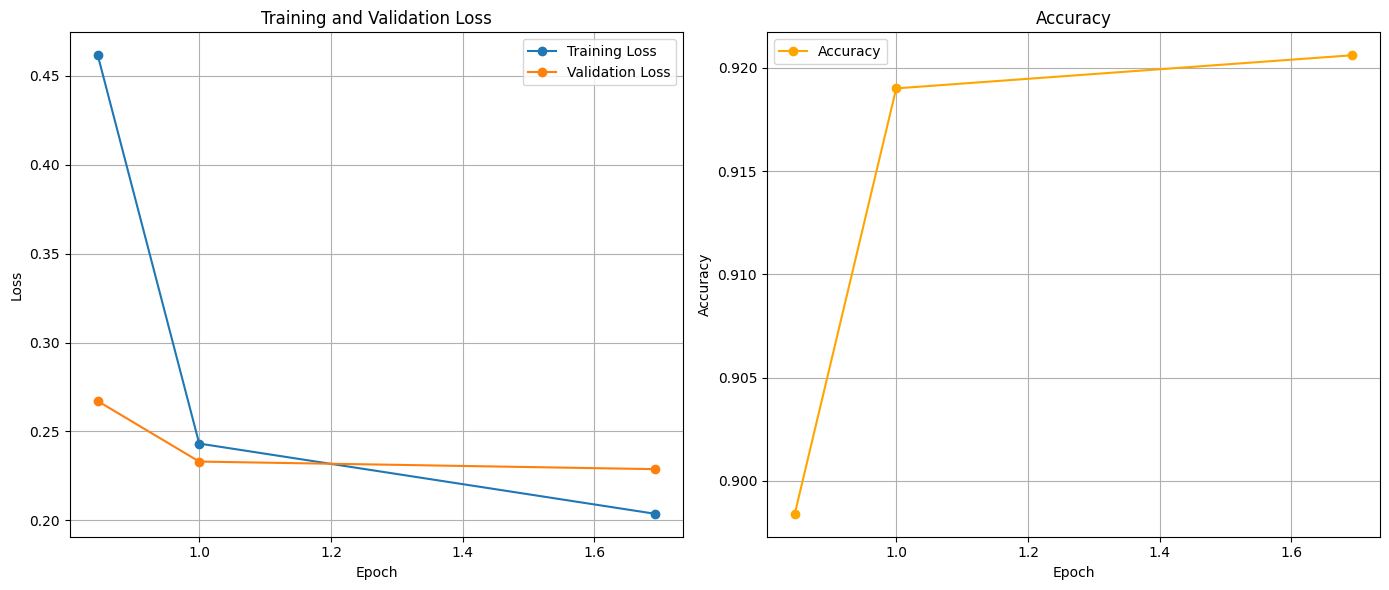

In [19]:
# Extract training logs
log_history = trainer.state.log_history

# Initialize lists to store data
epochs = []
train_losses = []
val_losses = []
accuracies = []

# Extract data from log history
for log in log_history:
    if 'epoch' in log:
        epochs.append(log['epoch'])
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        val_losses.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        accuracies.append(log['eval_accuracy'])

# Ensure the lists are of the same length by filtering out None values
filtered_data = [(e, tl, vl, acc) for e, tl, vl, acc in zip(epochs, train_losses, val_losses, accuracies)
                 if tl is not None and vl is not None and acc is not None]

if not filtered_data:
    print("No valid data found.")
else:
    epochs, train_losses, val_losses, accuracies = zip(*filtered_data)

    # Create a figure and axes for subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Plot Training and Validation Loss
    ax1.plot(epochs, train_losses, label='Training Loss', marker='o')
    ax1.plot(epochs, val_losses, label='Validation Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(epochs, accuracies, label='Accuracy', marker='o', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


In [20]:
# Save the model
model_save_path = './saved_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to ./saved_model


In [21]:
# Evaluate the model
eval_results = trainer.evaluate()

# Print classification report
val_preds = trainer.predict(val_dataset)
val_pred_labels = np.argmax(val_preds.predictions, axis=1)
print(classification_report(val_labels, val_pred_labels, target_names=list(label_mapping.keys())))

/tmp/ipykernel_24/581508825.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/tmp/ipykernel_24/581508825.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

    firewall       0.94      0.83      0.88      2025
     problem       0.83      0.92      0.87      2025
       other       0.96      0.96      0.96      2025
     onemail       0.96      0.98      0.97      2025

    accuracy                           0.92      8100
   macro avg       0.92      0.92      0.92      8100
weighted avg       0.92      0.92      0.92      8100



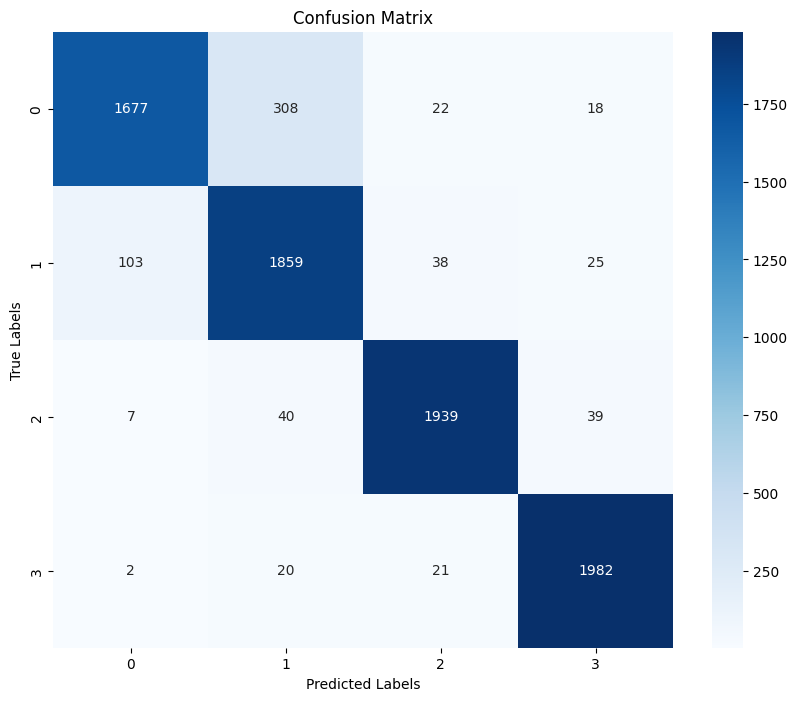

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## test

In [23]:
testdata = pd.read_csv('/kaggle/input/ticket/df_test_emailv2.csv')
testdata

,ticket_no,subject,description,type
0,230609348,Southland Rubber : รบกวนดำเนินการ allow IP 203...,From: Pairat Wattana <pairat.wa@barrelofexcell...,Cloud_issue
1,240318207,GetOn : รบกวนขอ Report Performance ประจำเดือน ...,From: Prapaporn Panthap <Prapaporn@innoco.co.t...,Cloud_issue
2,230227126,Summit Computer :แจ้งขอเข้าดำเนินการบำรุงรักษา...,From: Pisit Phantapanichakul <pisit@summitthai...,Other
3,230316227,Photonics Science : สอบถามวิธีการตรวจสอบ Acco...,"From: <chalit.s@photonics-science.com>\nTo: ""'...",One_Email
4,230220289,INTERNET COMMUNICATION : Access INET-IDC2 ในวั...,From: <surapong@internetcom.co.th>\nTo: <noc@i...,Other
...,...,...,...,...
3995,230328172,INETMS : รบกวนสร้าง E-mail,From: Linda Groen <linda.gr@inetms.co.th>\nTo:...,One_Email
3996,220503121,SCG [SD] : รบกวนขอรูปภาพ ตู้ C100 D100,"From: ""Pichitpon Simma"" <pichitpon.si@inet.co....",Other
3997,230322206,[Closed][OP-Sec] INET-INTERNAL : แจ้งรบกวนขอ L...,From: Peerapon Meekaew <peerapon.me@inet.co.th...,VFW
3998,24060321,Genex Infotech : NOC ได้รับ Alert VM : [PRD_Ge...,"\n\nFrom: ""Cloud Monitor"" <Cloud-Monitor@inet....",Cloud_issue


In [24]:
# Create a mapping for the new labels
new_label_mapping = {
    'Cloud_issue': 'problem',
    'VFW': 'firewall',
    'One_Email': 'onemail',
    'Other': 'other'
}

# Reverse the label mapping used in training
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert the new labels to the format used in the training data
testdata['label'] = testdata['type'].map(new_label_mapping).map(label_mapping)
testdata['label'].value_counts()

label
1    1000
2    1000
3    1000
0    1000
Name: count, dtype: int64

In [25]:
# Apply preprocessing
testdata['clean_subject'] = testdata['subject'].apply(extract_email_subject)
testdata['clean_description'] = testdata['description'].apply(extract_email_body)

# Combine the cleaned subject and description into a single text field
testdata['text'] = testdata['clean_subject'] + ' ' + testdata['clean_description']
# Tokenize the new data
test_encodings = tokenizer(testdata['text'].tolist(), truncation=True, padding=True, max_length=512)

In [26]:
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

test_dataset = CustomTestDataset(test_encodings)

In [27]:
# Make predictions
test_preds = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_preds.predictions, axis=1)

# Map the predicted labels back to the original class names
predicted_labels = [reverse_label_mapping[label] for label in test_pred_labels]

# Create a DataFrame with predictions
testdata['predicted_label'] = predicted_labels

              precision    recall  f1-score   support

    firewall       0.86      0.97      0.91      1000
     problem       0.94      0.94      0.94      1000
       other       0.98      0.97      0.97      1000
     onemail       1.00      0.90      0.94      1000

    accuracy                           0.94      4000
   macro avg       0.95      0.94      0.94      4000
weighted avg       0.95      0.94      0.94      4000



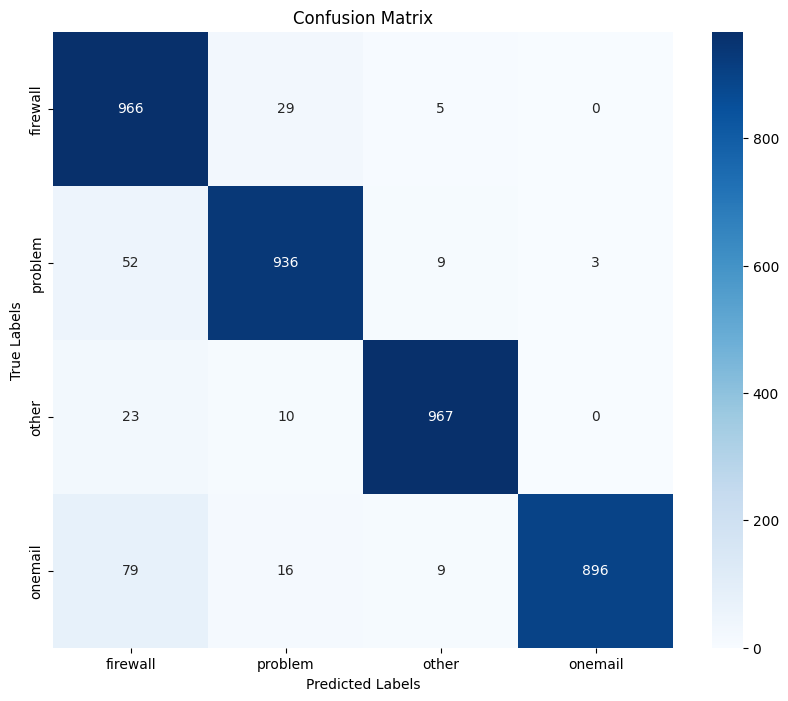

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have ground truth labels in a column named 'true_label'
# Compute the confusion matrix
conf_matrix = confusion_matrix(testdata['label'], test_pred_labels)

# Print the classification report
print(classification_report(testdata['label'], test_pred_labels, target_names=list(label_mapping.keys())))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
testdata

,ticket_no,subject,description,type,label,clean_subject,clean_description,text,predicted_label
0,230609348,Southland Rubber : รบกวนดำเนินการ allow IP 203...,From: Pairat Wattana <pairat.wa@barrelofexcell...,Cloud_issue,1,รบกวนดำเนินการ allow IP 203.150.207.20 ให้กับ...,From: Pairat Wattana <pairat.wa@barrelofexcell...,รบกวนดำเนินการ allow IP 203.150.207.20 ให้กับ...,problem
1,240318207,GetOn : รบกวนขอ Report Performance ประจำเดือน ...,From: Prapaporn Panthap <Prapaporn@innoco.co.t...,Cloud_issue,1,รบกวนขอ Report Performance ประจำเดือน กุมภาพัน...,From: Prapaporn Panthap <Prapaporn@innoco.co.t...,รบกวนขอ Report Performance ประจำเดือน กุมภาพัน...,problem
2,230227126,Summit Computer :แจ้งขอเข้าดำเนินการบำรุงรักษา...,From: Pisit Phantapanichakul <pisit@summitthai...,Other,2,แจ้งขอเข้าดำเนินการบำรุงรักษาอุปกรณ์HSM ที่ Si...,From: Pisit Phantapanichakul <pisit@summitthai...,แจ้งขอเข้าดำเนินการบำรุงรักษาอุปกรณ์HSM ที่ Si...,other
3,230316227,Photonics Science : สอบถามวิธีการตรวจสอบ Acco...,"From: <chalit.s@photonics-science.com>\nTo: ""'...",One_Email,3,สอบถามวิธีการตรวจสอบ Account ปลายทาง,"From: <chalit.s@photonics-science.com>\nTo: ""'...",สอบถามวิธีการตรวจสอบ Account ปลายทาง From: <ch...,onemail
4,230220289,INTERNET COMMUNICATION : Access INET-IDC2 ในวั...,From: <surapong@internetcom.co.th>\nTo: <noc@i...,Other,2,Access INET-IDC2 ในวันที่ 20/02/2023 เวลา 15:3...,From: <surapong@internetcom.co.th>\nTo: <noc@i...,Access INET-IDC2 ในวันที่ 20/02/2023 เวลา 15:3...,other
...,...,...,...,...,...,...,...,...,...
3995,230328172,INETMS : รบกวนสร้าง E-mail,From: Linda Groen <linda.gr@inetms.co.th>\nTo:...,One_Email,3,รบกวนสร้าง E-mail,From: Linda Groen <linda.gr@inetms.co.th>\nTo:...,รบกวนสร้าง E-mail From: Linda Groen <linda.gr@...,onemail
3996,220503121,SCG [SD] : รบกวนขอรูปภาพ ตู้ C100 D100,"From: ""Pichitpon Simma"" <pichitpon.si@inet.co....",Other,2,: รบกวนขอรูปภาพ ตู้ C100 D100,"From: ""Pichitpon Simma"" <pichitpon.si@inet.co....",": รบกวนขอรูปภาพ ตู้ C100 D100 From: ""Pichitpon...",other
3997,230322206,[Closed][OP-Sec] INET-INTERNAL : แจ้งรบกวนขอ L...,From: Peerapon Meekaew <peerapon.me@inet.co.th...,VFW,0,[OP-Sec] INET-INTERNAL : แจ้งรบกวนขอ List IP บ...,From: Peerapon Meekaew <peerapon.me@inet.co.th...,[OP-Sec] INET-INTERNAL : แจ้งรบกวนขอ List IP บ...,firewall
3998,24060321,Genex Infotech : NOC ได้รับ Alert VM : [PRD_Ge...,"\n\nFrom: ""Cloud Monitor"" <Cloud-Monitor@inet....",Cloud_issue,1,NOC ได้รับ Alert VM : [PRD_GenexInfotech02_Win...,"From: ""Cloud Monitor"" <Cloud-Monitor@inet.co.t...",NOC ได้รับ Alert VM : [PRD_GenexInfotech02_Win...,problem


In [30]:
# Define the mapping from 'type' to 'predicted_label'
type_to_label_mapping = {
    'Cloud_issue': 'problem',
    'VFW': 'firewall',
    'One_Email': 'onemail',
    'Other': 'other'
}

# Apply the mapping to the 'type' column
testdata['mapped_type'] = testdata['type'].map(type_to_label_mapping)
testdata['correct'] = testdata['predicted_label'] == testdata['mapped_type']
incorrect_predictions = testdata[~testdata['correct']]

In [31]:
testdata['predicted_label'].value_counts()

predicted_label
firewall    1120
problem      991
other        990
onemail      899
Name: count, dtype: int64

In [32]:
incorrect_predictions[['predicted_label','mapped_type']].iloc[100]

predicted_label    firewall
mapped_type           other
Name: 1807, dtype: object

In [33]:
print(incorrect_predictions['clean_description'].iloc[100])

From: "NETWORK-ALERT" <NETWORK-ALERT@INET.CO.TH>
To: netmon@inet.co.th
Sent: Saturday, December 10, 2022 12:10:07 PM

Sat Dec 10 12:10:05 2022
Device IDC3.BD-02
IP:10.11.13.191

Interface GigabitEthernet2/1/1
Description *** Connected to IDC3-DSW-CLOUD-MGMT-PHASE2 ***
Status change UP to DOWN


## clue

- ส่วนใหญ่จะทำนาย firewall เนื่องจากเมลมี ip address หรือ คำว่า firewall
- ส่วนคลาส other กับ cloud problem คือแยกยากเกินไปจริงๆ คนอ่าน(หนู)ยังแยกไม่ออกเลย

In [34]:
# import os

# # List files in the directory to check if the file exists
# print(os.listdir('/kaggle/working/saved_model'))

In [35]:
# import shutil

# # Path to the directory you want to zip
# directory_path = '/kaggle/working/saved_model'
# zip_path = '/kaggle/working/saved_model.zip'

# # Create a ZIP file from the directory
# shutil.make_archive('/kaggle/working/saved_model', 'zip', directory_path)

In [36]:
# from IPython.display import FileLink

# # Create a downloadable link for the ZIP file
# FileLink('/kaggle/working/saved_model.zip')